# EDA: Financial Risk Profiling

**Objective:** Explore and understand the training dataset (`train_updated.csv`) before preprocessing and modelling.
We will:  
- load and inspect the data,  
- check missing values and target balance,  
- split numeric vs categorical features,  
- examine distributions and correlations,  
- preview categorical value counts.  

All code cells below are Colab-ready.


## **Load data & basic info**

In [ ]:
# Cell: Load dataset and show basic info
import pandas as pd
import numpy as np

DATA_PATH = "train_updated.csv"
df = pd.read_csv(DATA_PATH)

# Basic info
print("Rows, Columns:", df.shape)
print("\nColumn names:\n", df.columns.tolist()[:100])  # show up to first 100 column names
print("\nData types:")
print(df.dtypes)

# Show first 10 rows to inspect sample values
display(df.head(10))


Rows, Columns: (204277, 18)

Column names:
 ['ProfileID', 'ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor', 'QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant', 'RiskFlag']

Data types:
ProfileID              object
ApplicantYears          int64
AnnualEarnings          int64
RequestedSum            int64
TrustMetric             int64
WorkDuration            int64
ActiveAccounts          int64
OfferRate             float64
RepayPeriod             int64
DebtFactor            float64
QualificationLevel     object
WorkCategory           object
RelationshipStatus     object
OwnsProperty           object
FamilyObligation       object
FundUseCase            object
JointApplicant         object
RiskFlag                int64
dtype: object


,ProfileID,ApplicantYears,AnnualEarnings,RequestedSum,TrustMetric,WorkDuration,ActiveAccounts,OfferRate,RepayPeriod,DebtFactor,QualificationLevel,WorkCategory,RelationshipStatus,OwnsProperty,FamilyObligation,FundUseCase,JointApplicant,RiskFlag
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,High School,Self-employed,Single,Yes,No,Business,No,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,High School,Unemployed,Divorced,No,Yes,Education,No,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,Master's,Self-employed,Married,No,No,Other,Yes,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,Bachelor's,Self-employed,Single,Yes,No,Auto,Yes,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,Bachelor's,Part-time,Single,No,Yes,Education,Yes,0
5,UVT2FMEWUR,33,44855,39393,416,80,4,16.25,12,0.76,Bachelor's,Unemployed,Single,No,No,Other,Yes,0
6,023MJWH6AS,22,20216,153128,692,90,4,22.91,60,0.32,High School,Self-employed,Married,No,Yes,Auto,No,0
7,W2J1SLV57M,57,90343,71189,345,102,4,12.98,12,0.71,Bachelor's,Unemployed,Married,No,Yes,Other,Yes,0
8,QGIXFHVHO1,49,35880,96919,353,33,2,10.97,24,0.31,PhD,Self-employed,Divorced,Yes,No,Other,Yes,1
9,QRZHVC1HRR,19,71995,23105,587,105,2,2.06,12,0.38,High School,Unemployed,Divorced,No,Yes,Other,Yes,0


This cell loads the training CSV and prints basic information: number of rows & columns, first rows to inspect columns and sample values, and each column's data type. This helps spot id columns, mistyped numeric/text columns, and get an initial feel for the dataset.

## **Missing values**

In [ ]:
# Cell: Missing values summary
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(3)
missing_tbl = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

display(missing_tbl.head(60))   # show top 60; change if you want more
missing_tbl.to_csv("missing_table.csv", index=True)
print("Saved missing table to missing_table.csv")


,missing_count,missing_percent
ProfileID,0,0.0
ApplicantYears,0,0.0
AnnualEarnings,0,0.0
RequestedSum,0,0.0
TrustMetric,0,0.0
WorkDuration,0,0.0
ActiveAccounts,0,0.0
OfferRate,0,0.0
RepayPeriod,0,0.0
DebtFactor,0,0.0


Saved missing table to missing_table.csv


We compute the number and percentage of missing values per column. Columns with large missing percentages will be candidates for dropping; low-missing columns can be imputed. We save the summary to a CSV for reference.

## **Target distribution**

In [ ]:
# Cell: Target distribution check
target_col = "RiskFlag"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataframe.")

target_counts = df[target_col].value_counts(dropna=False)
target_percent = (target_counts / len(df) * 100).round(3)
target_df = pd.concat([target_counts, target_percent], axis=1)
target_df.columns = ["count", "percent"]
display(target_df)


,count,percent
RiskFlag,,
0,180524,88.372
1,23753,11.628


We check the distribution of the target RiskFlag to see if classes are balanced. If classes are imbalanced we will plan special handling (class weights, resampling or proper metrics).

## **Numeric vs Categorical split**

In [ ]:
# Cell: Identify numeric and categorical features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# If ProfileID is numeric, treat it as ID (exclude from numeric features)
if "ProfileID" in numeric_cols:
    numeric_cols.remove("ProfileID")

print("Number of numeric features:", len(numeric_cols))
print("Number of categorical features:", len(categorical_cols))
print("\nSample numeric cols:", numeric_cols[:20])
print("\nSample categorical cols:", categorical_cols[:20])


Number of numeric features: 10
Number of categorical features: 8

Sample numeric cols: ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor', 'RiskFlag']

Sample categorical cols: ['ProfileID', 'QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']


We separate numeric and categorical features. This tells us which columns need scaling and which need encoding. Also check for numeric ID fields (e.g., ProfileID) which should be excluded from modelling.

## **Numeric summary + skewness**

In [ ]:
# Cell: Numeric summary and skew
numeric_summary = df[numeric_cols].describe().T
numeric_summary['skew'] = df[numeric_cols].skew().round(3)
display(numeric_summary.sort_values('skew', ascending=False).head(60))
# Save numeric summary
numeric_summary.to_csv("numeric_summary.csv")
print("Saved numeric summary to numeric_summary.csv")


,count,mean,std,min,25%,50%,75%,max,skew
RiskFlag,204277.0,0.116278,0.320559,0.0,0.00,0.00,0.00,1.0,2.394
TrustMetric,204277.0,574.075500,158.877098,300.0,437.00,574.00,712.00,849.0,0.006
OfferRate,204277.0,13.488147,6.636060,2.0,7.76,13.45,19.24,25.0,0.005
ApplicantYears,204277.0,43.489340,14.995191,18.0,31.00,43.00,56.00,69.0,0.001
AnnualEarnings,204277.0,82506.227980,38952.103374,15000.0,48878.00,82400.00,116247.00,149999.0,0.001
WorkDuration,204277.0,59.508511,34.645589,0.0,30.00,59.00,90.00,119.0,-0.001
RepayPeriod,204277.0,36.010926,16.944827,12.0,24.00,36.00,48.00,60.0,-0.001
RequestedSum,204277.0,127547.496395,70855.064746,5001.0,66059.00,127603.00,188843.00,249999.0,-0.002
ActiveAccounts,204277.0,2.502078,1.116898,1.0,2.00,3.00,4.00,4.0,-0.002
DebtFactor,204277.0,0.500579,0.230914,0.1,0.30,0.50,0.70,0.9,-0.003


Saved numeric summary to numeric_summary.csv


For numeric features we show summary statistics (mean, std, quantiles) and compute skewness. Highly skewed columns (skewness > 1 or < -1) may benefit from log or other transforms.

# Cell: Plot histograms & boxplots for the first N numeric columns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plot_cols = numeric_cols[:8]   # change number as needed
for col in plot_cols:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].hist(df[col].dropna(), bins=40)
    ax[0].set_title(f"Histogram: {col}")
    ax[0].set_xlabel(col)

    ax[1].boxplot(df[col].dropna(), vert=False)
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


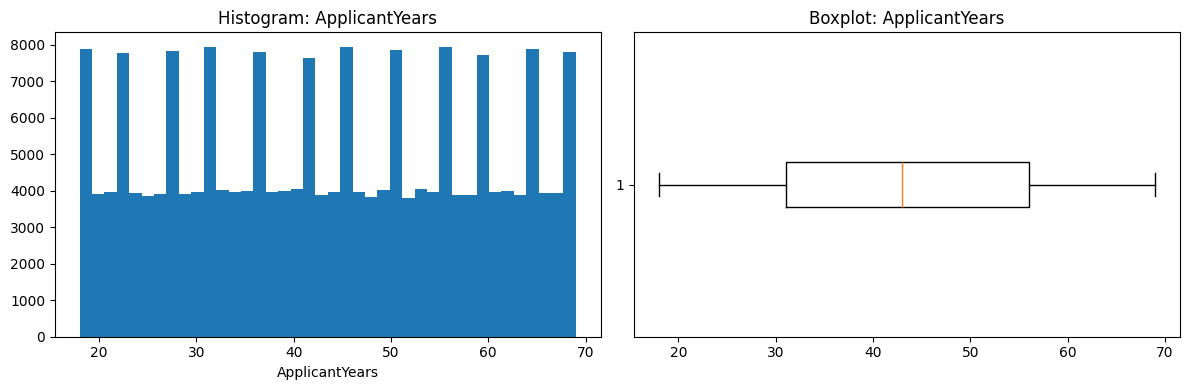

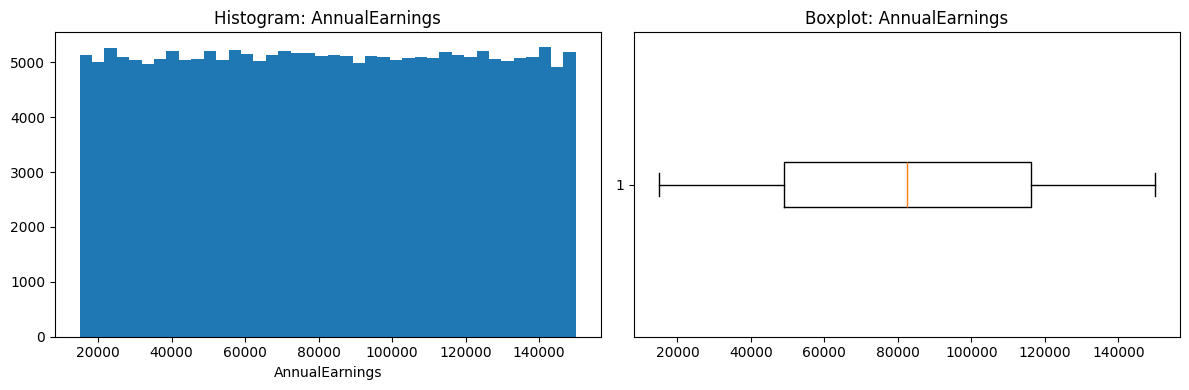

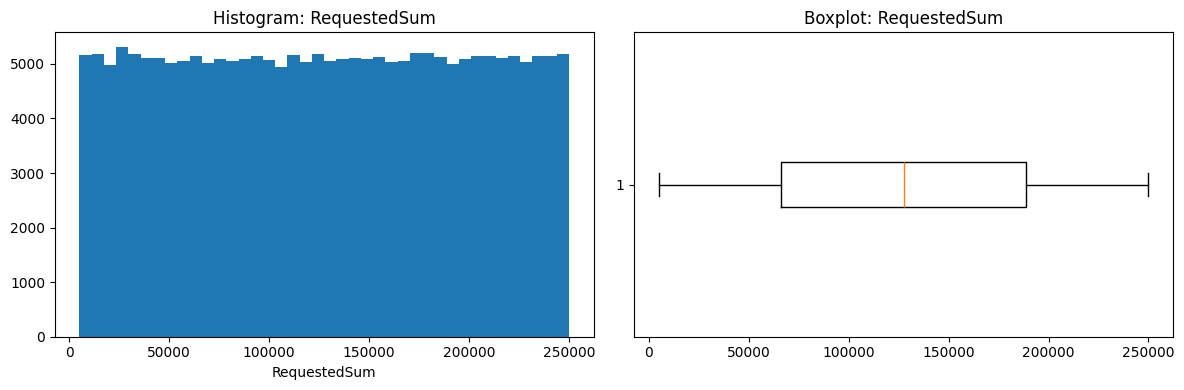

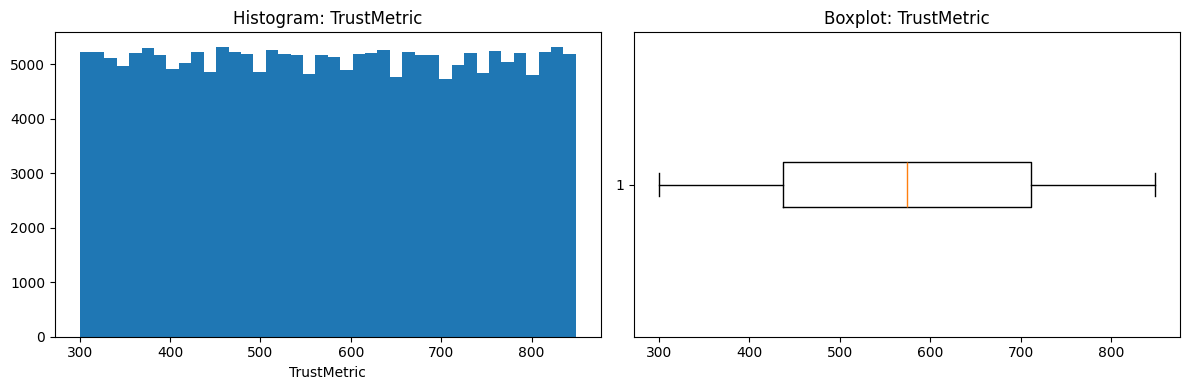

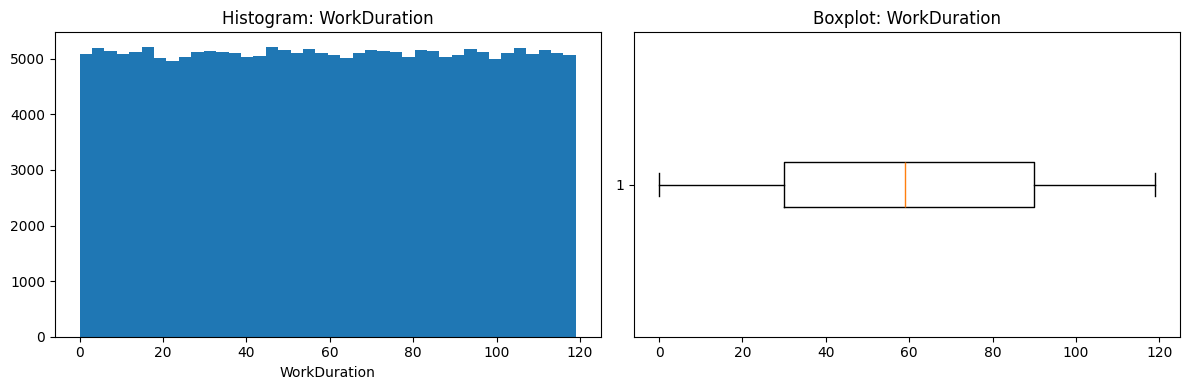

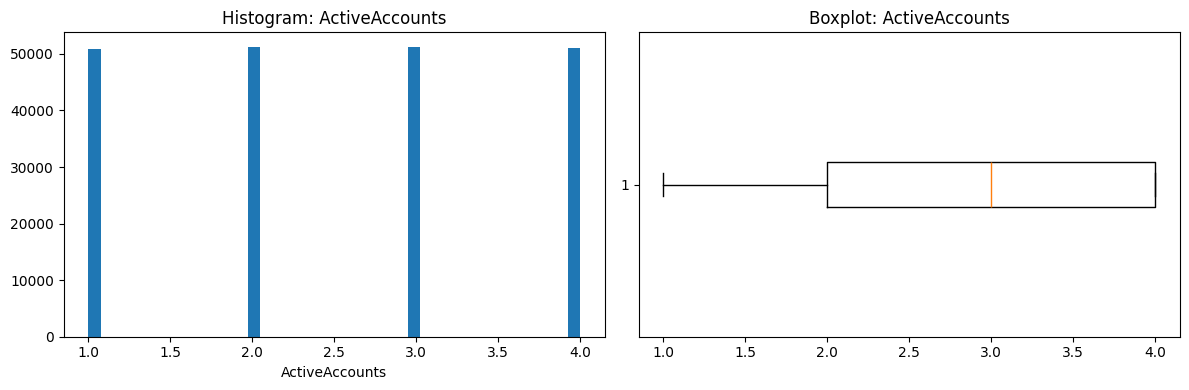

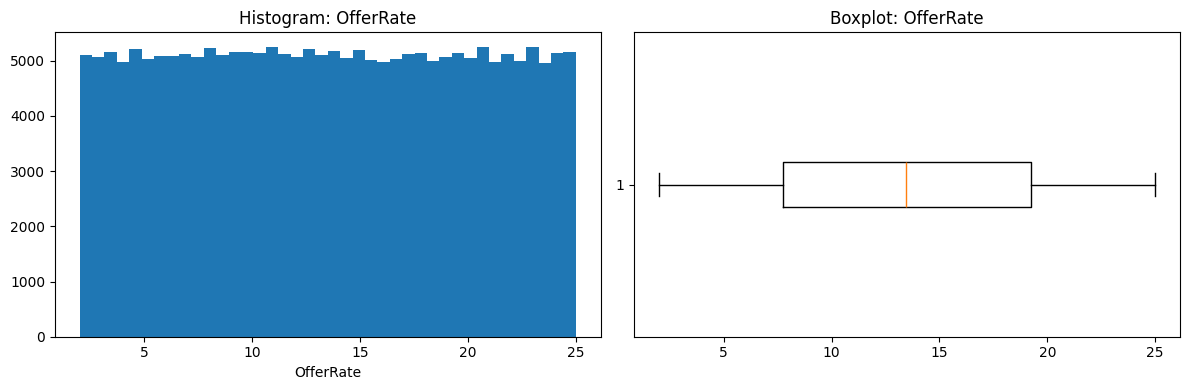

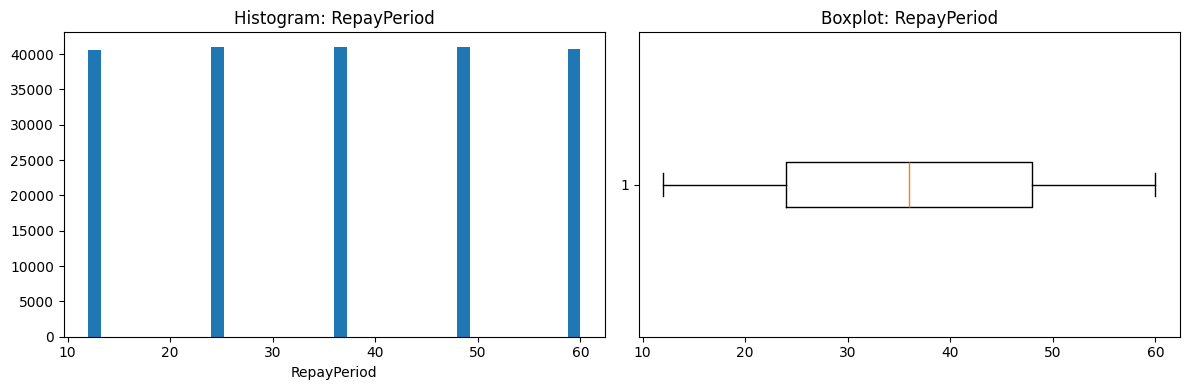

In [ ]:
# Cell: Plot histograms & boxplots for the first N numeric columns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plot_cols = numeric_cols[:8]   # change number as needed
for col in plot_cols:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].hist(df[col].dropna(), bins=40)
    ax[0].set_title(f"Histogram: {col}")
    ax[0].set_xlabel(col)

    ax[1].boxplot(df[col].dropna(), vert=False)
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


Visualizing distributions helps detect outliers and shape (skew). We plot histograms and boxplots for the top numeric columns — start with a few to keep output readable.

## **Correlation with target**

In [ ]:
# Cell: Correlation with the target (numeric features)
corrs = {}
for c in numeric_cols:
    try:
        corrs[c] = df[c].corr(df[target_col])
    except:
        corrs[c] = np.nan

corr_df = pd.DataFrame.from_dict(corrs, orient='index', columns=['corr_with_target']).sort_values('corr_with_target', ascending=False)
display(corr_df.head(40))
corr_df.to_csv("corr_with_target.csv")
print("Saved correlations to corr_with_target.csv")


,corr_with_target
RiskFlag,1.000000
OfferRate,0.129885
RequestedSum,0.085519
ActiveAccounts,0.028565
DebtFactor,0.018595
RepayPeriod,0.000815
TrustMetric,-0.034128
WorkDuration,-0.095429
AnnualEarnings,-0.100515
ApplicantYears,-0.167484


Saved correlations to corr_with_target.csv


We compute Pearson correlation between numeric features and the binary target. This is a simple, fast measure to see which numeric features are roughly aligned with the target (not definitive — use carefully). We save results.

## **Categorical value counts + cardinality**

In [ ]:
# Cell: Categorical cardinality and top values
card_list = []
for c in categorical_cols:
    nunique = df[c].nunique(dropna=False)
    top = df[c].value_counts(dropna=False).head(5).to_dict()
    card_list.append((c, nunique, top))

cat_card_df = pd.DataFrame(card_list, columns=['column','n_unique','top_values'])
display(cat_card_df.sort_values('n_unique', ascending=False).head(60))
cat_card_df.to_csv("categorical_cardinality.csv", index=False)
print("Saved categorical cardinality to categorical_cardinality.csv")


,column,n_unique,top_values
0,ProfileID,204277,"{'SVGAIO53ZK': 1, 'DRIRC89L0T': 1, 'TS0FIUNHNU..."
6,FundUseCase,5,"{'Business': 40984, 'Home': 40878, 'Education'..."
2,WorkCategory,4,"{'Part-time': 51460, 'Unemployed': 50994, 'Ful..."
1,QualificationLevel,4,"{'Bachelor's': 51483, 'High School': 51046, 'P..."
3,RelationshipStatus,3,"{'Married': 68217, 'Divorced': 68137, 'Single'..."
4,OwnsProperty,2,"{'Yes': 102145, 'No': 102132}"
5,FamilyObligation,2,"{'Yes': 102180, 'No': 102097}"
7,JointApplicant,2,"{'Yes': 102196, 'No': 102081}"


Saved categorical cardinality to categorical_cardinality.csv


For each categorical column we show the number of unique values and top category frequencies. Columns with very high cardinality (many unique values) need special encoding (frequency/target encoding or embeddings) — one-hot is not suitable for those.

**Quick class-wise statistics for top numeric features**

In [ ]:
# Cell: Class-wise stats for top numeric features (by absolute correlation)
top_feats = corr_df['corr_with_target'].abs().sort_values(ascending=False).head(6).index.tolist()
print("Top numeric features by absolute correlation:", top_feats)

display(df.groupby(target_col)[top_feats].agg(['count','mean','median','std']).transpose())


Top numeric features by absolute correlation: ['RiskFlag', 'ApplicantYears', 'OfferRate', 'AnnualEarnings', 'WorkDuration', 'RequestedSum']


RiskFlag                           0              1
RiskFlag       count   180524.000000   23753.000000
               mean         0.000000       1.000000
               median       0.000000       1.000000
               std          0.000000       0.000000
ApplicantYears count   180524.000000   23753.000000
               mean        44.400335      36.565739
               median      45.000000      34.000000
               std         14.893253      13.920336
OfferRate      count   180524.000000   23753.000000
               mean        13.175497      15.864305
               median      12.990000      16.900000
               std          6.612190       6.328767
AnnualEarnings count   180524.000000   23753.000000
               mean     83926.432641   71712.600808
               median   84207.500000   66372.000000
               std      38491.991564   40697.852591
WorkDuration   count   180524.000000   23753.000000
               mean        60.707790      50.393929
               median      61.000000      46.000000
               std         34.560769      33.925975
RequestedSum   count   180524.000000   23753.000000
               mean    125349.517621  144252.246116
               median  124376.000000  152121.000000
               std      70741.213804   69479.470570

We compare means/medians of the top correlated numeric features grouped by the target. This helps check if the feature distributions differ between defaulters and non-defaulters.

# **PREPROCESSING**

## Missing Value Treatment

The dataset was checked for missing values. The percentage of missing values
was extremely low across all columns. Since the dataset does not contain any
column with high missing percentages, we adopted a simple and appropriate
imputation strategy:

- Numerical columns → imputed with the **median**  
- Categorical columns → imputed with the **mode** (most frequent value)  
- Columns with no missing values were left unchanged  

This ensures the dataset has no NULL values and is ready for further
preprocessing steps like encoding and scaling.


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/train_updated.csv")   # update path if needed

# Identify features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Exclude target and ID if present
if "RiskFlag" in numeric_cols:
    numeric_cols.remove("RiskFlag")
if "ProfileID" in df.columns:
    # treat ID as non-feature (remove from lists if present)
    if "ProfileID" in numeric_cols: numeric_cols.remove("ProfileID")
    if "ProfileID" in categorical_cols: categorical_cols.remove("ProfileID")

# Numerical imputation (median) - safe assignment form
for col in numeric_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Categorical imputation (mode) - safe assignment form
for col in categorical_cols:
    mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
    df[col] = df[col].fillna(mode_val)

# Verify
print("Remaining missing values:", df.isnull().sum().sum())


Remaining missing values: 0


### Identify features and split into numeric vs categorical

Before any encoding or scaling, we first separate the columns that will be used as features from the target and ID columns.

- Remove the `RiskFlag` column (target) from the feature set so we do not accidentally feed the label into the model.
- Remove `ProfileID` (unique identifier) because it carries no predictive value.
- Detect which remaining features are numeric (numbers) and which are categorical (text or categories).

This information helps decide later steps:
- Numeric columns will be scaled.
- Categorical columns will be encoded (one-hot, frequency, or other methods depending on cardinality).


In [ ]:
#  Identify features and split into numeric and categorical
import pandas as pd
import numpy as np

# Adjust path if using Colab: upload file to /content and change path accordingly
DATA_PATH = "train_updated.csv"   # or "/mnt/data/train_updated.csv"
df = pd.read_csv(DATA_PATH)

# Safety checks
expected_target = "RiskFlag"
expected_id = "ProfileID"

# Compose feature list (exclude target and ID)
features = [c for c in df.columns if c != expected_target and c != expected_id]

# Numeric and categorical detection
numeric_cols = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df[features].select_dtypes(include=["object", "category"]).columns.tolist()

# Additionally treat numeric columns with small #unique values as categorical candidates (optional)
# (uncomment the next lines if you want this behaviour)
# for c in numeric_cols.copy():
#     if df[c].nunique() <= 10:
#         numeric_cols.remove(c)
#         categorical_cols.append(c)

# Report results
print(f"Total columns in original data: {df.shape[1]}")
print(f"Features selected (excluding target and ID): {len(features)}")
print("Sample features (first 30):", features[:30])
print("\nNumber of numeric features:", len(numeric_cols))
print("Numeric feature examples:", numeric_cols[:20])
print("\nNumber of categorical features:", len(categorical_cols))
print("Categorical feature examples:", categorical_cols[:20])

# Save lists to disk for later steps
pd.Series(numeric_cols).to_csv("numeric_columns_list.csv", index=False)
pd.Series(categorical_cols).to_csv("categorical_columns_list.csv", index=False)
print("\nSaved numeric and categorical column lists ")


Total columns in original data: 18
Features selected (excluding target and ID): 16
Sample features (first 30): ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor', 'QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']

Number of numeric features: 9
Numeric feature examples: ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']

Number of categorical features: 7
Categorical feature examples: ['QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']

Saved numeric and categorical column lists 


Identify categorical columns that have a small number of unique categories and convert them to numeric using one-hot encoding.

Why this is done:
- One-hot encoding turns each category into its own binary column (0/1), which is easy for models to use.
- This method is appropriate when the number of categories is small (we use ≤ 10 as a rule of thumb) to avoid creating too many new columns.
- Columns with many categories will be handled differently later to prevent explosion of features.

We will:
- Load the saved list of categorical columns,
- Pick columns whose unique-value count is ≤ 10,
- Apply pandas' `get_dummies()` to create one-hot columns for these features,
- Save the updated DataFrame and lists of features for the next stage.


In [ ]:
import pandas as pd
import numpy as np
import os

DATA_PATH = "train_updated.csv"   # use your local CSV directly
df = pd.read_csv(DATA_PATH)

# Try to load a previously saved categorical column list (if it exists)
cat_list_path = "categorical_columns_list.csv"
categorical_cols = None

if os.path.exists(cat_list_path):
    try:
        tmp = pd.read_csv(cat_list_path, header=None)
        flat = []
        for col in tmp.columns:
            flat.extend([str(x).strip() for x in tmp[col].dropna().tolist()])
        # Keep only valid column names
        categorical_cols = [c for c in flat if c in df.columns]
        if len(categorical_cols) == 0:
            categorical_cols = None
    except:
        categorical_cols = None

# If no list found or it was invalid → auto detect
if categorical_cols is None:
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Remove ID & target if present
for reserved in ("ProfileID", "RiskFlag"):
    if reserved in categorical_cols:
        categorical_cols.remove(reserved)

print("Categorical columns detected:", categorical_cols)
print("Total categorical columns:", len(categorical_cols))

# Identify low-cardinality (<=10 unique)
low_cardinality = [c for c in categorical_cols if df[c].nunique(dropna=False) <= 10]

print("\nLow-cardinality categorical columns (<=10 unique):", low_cardinality)

if len(low_cardinality) == 0:
    print("No low-cardinality categorical columns found.")
else:
    # Apply One-Hot Encoding
    df_ohe = pd.get_dummies(df, columns=low_cardinality, prefix=low_cardinality, dummy_na=False)

    print("Original shape:", df.shape)
    print("Shape after one-hot encoding:", df_ohe.shape)

    # Save file (directly in working directory)
    df_ohe.to_csv("train_ohe_lowcard.csv", index=False)
    print("Saved: train_ohe_lowcard.csv")

    # Update feature lists after OHE
    features = [c for c in df_ohe.columns if c not in ("RiskFlag", "ProfileID")]
    numeric_cols = df_ohe[features].select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols_remaining = [c for c in features if c not in numeric_cols]

    # Save lists without /content
    pd.Series(numeric_cols).to_csv("numeric_columns_list_after_ohe.csv", index=False)
    pd.Series(categorical_cols_remaining).to_csv("categorical_columns_list_after_ohe.csv", index=False)

    print("Saved: numeric_columns_list_after_ohe.csv")
    print("Saved: categorical_columns_list_after_ohe.csv")


Categorical columns detected: ['QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']
Total categorical columns: 7

Low-cardinality categorical columns (<=10 unique): ['QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']
Original shape: (204277, 18)
Shape after one-hot encoding: (204277, 33)
Saved: train_ohe_lowcard.csv
Saved: numeric_columns_list_after_ohe.csv
Saved: categorical_columns_list_after_ohe.csv


### Encoding medium/high-cardinality categorical columns

What is "cardinality"?  
- Cardinality means the number of unique categories a column has.  
  - Example: `OwnsProperty` has low cardinality (maybe values `0` and `1`).  
  - Example: `FundUseCase` might have many different purposes → high cardinality.

Why not use one-hot encoding for high-cardinality columns?  
- One-hot encoding creates one new column per category. If a column has 100 unique categories, one-hot will add 100 new columns.
- Too many columns → slows training, uses lots of memory, and can make models worse.

What is frequency encoding (very simple)?  
- Replace each category by how common it is: the fraction (or count) of rows that have that category.
- Example: if category "education=Graduate" appears 20% of rows, it becomes 0.20.
- This keeps the column numeric, is compact (1 column), and gives the model a sense of how “common” a category is.

Why frequency encoding here?  
- It’s simple, fast, and safe for SVMs and Neural Networks.
- It avoids creating lots of extra columns.
- It preserves information about rarity/popularity of categories which is often useful.

What we will do:
1. Load the most recent intermediate file (if available) or the original dataset.  
2. Detect categorical columns that still remain (excluding those already one-hot encoded).  
3. For columns with >10 unique categories, create a new column named `COLUMN_freq_enc` that contains the category frequency (a number between 0 and 1).  
4. Drop the original high-cardinality column to avoid duplication.  
5. Save the resulting dataset as `train_encoded.csv` for the next steps (scaling, train/test split, modelling).


In [ ]:
# Frequency-encoding for medium/high-cardinality categorical columns
import pandas as pd
import numpy as np
import os

# Load the most recent intermediate file if it exists, otherwise load original
if os.path.exists("train_ohe_lowcard.csv"):
    df = pd.read_csv("train_ohe_lowcard.csv")
    print("Loaded: train_ohe_lowcard.csv (contains one-hot encoded low-card columns)")
else:
    df = pd.read_csv("train_updated.csv")
    print("Loaded: train_updated.csv (original file)")

# Ensure ID/target are present and not treated as features
target_col = "RiskFlag"
id_col = "ProfileID"

# Recompute feature lists
features = [c for c in df.columns if c not in (target_col, id_col)]
# Detect categorical candidates as non-numeric columns (strings) and remaining object/category dtypes
categorical_candidates = df[features].select_dtypes(include=["object", "category"]).columns.tolist()

# Also, some columns might be numeric dtype but actually categorical (small unique count)
# We treat columns with dtype int/float and small unique count as categorical candidates optionally.
# We'll only frequency-encode columns with > 10 unique values; so numeric small-unique columns are safe left as numeric.
# Build final list of categorical candidates to consider
print("Initially detected categorical columns (sample):", categorical_candidates[:40])

# Filter out any columns that were already one-hot encoded (they will contain '_' from prefix if we used prefix)
# To be safe, only consider columns that actually exist in the dataframe and are non-numeric
final_categoricals = [c for c in categorical_candidates if c in df.columns]

# Identify medium/high-cardinality columns: unique count > 10
med_high_card_cols = [c for c in final_categoricals if df[c].nunique(dropna=False) > 10]

print("Medium/High-cardinality columns (to freq-encode):", med_high_card_cols)

# If none found, inform and save current frame as train_encoded.csv (no-op)
if len(med_high_card_cols) == 0:
    print("No medium/high-cardinality categorical columns found. Saving current dataframe as train_encoded.csv.")
    df.to_csv("train_encoded.csv", index=False)
else:
    # Apply frequency encoding
    for col in med_high_card_cols:
        freq = df[col].value_counts(dropna=False) / len(df)     # fraction of rows per category
        new_col = f"{col}_freq_enc"
        # Map categories to frequency values; keep NaNs mapped as 0.0 (or you may choose another number)
        df[new_col] = df[col].map(freq).astype(float).fillna(0.0)
        print(f"Created frequency-encoded column: {new_col}")

    # Drop the original med/high-cardinality categorical columns
    df.drop(columns=med_high_card_cols, inplace=True)
    print("Dropped original high-cardinality categorical columns:", med_high_card_cols)

    # Save the resulting dataframe (directly into working directory)
    df.to_csv("train_encoded.csv", index=False)
    print("Saved: train_encoded.csv")

# Save updated lists for later steps
# Recompute numeric and categorical lists
features_after = [c for c in df.columns if c not in (target_col, id_col)]
numeric_cols = df[features_after].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_remaining = [c for c in features_after if c not in numeric_cols]

pd.Series(numeric_cols).to_csv("numeric_columns_list_after_encoding.csv", index=False)
pd.Series(categorical_cols_remaining).to_csv("categorical_columns_list_after_encoding.csv", index=False)
print("Saved column lists: numeric_columns_list_after_encoding.csv and categorical_columns_list_after_encoding.csv")


Loaded: train_ohe_lowcard.csv (contains one-hot encoded low-card columns)
Initially detected categorical columns (sample): []
Medium/High-cardinality columns (to freq-encode): []
No medium/high-cardinality categorical columns found. Saving current dataframe as train_encoded.csv.
Saved column lists: numeric_columns_list_after_encoding.csv and categorical_columns_list_after_encoding.csv


In [ ]:
# Preprocess train and test (imputation + one-hot low-card + freq-encode high-card)
# DOES NOT perform scaling. Save outputs for later scaling step.
import pandas as pd
import numpy as np
import os

# Filenames (must be in same directory as notebook)
TRAIN_SRC = "train_updated.csv"
TEST_SRC  = "test_updated.csv"

# Output filenames (pre-encoding outputs, ready for scaling)
TRAIN_OUT = "train_preencoded.csv"
TEST_OUT  = "test_preencoded.csv"

# Safety: check files exist
for f in (TRAIN_SRC, TEST_SRC):
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing required file: {f}. Place it in the working directory.")

# Load
train = pd.read_csv(TRAIN_SRC)
test  = pd.read_csv(TEST_SRC)

# Columns to exclude from features
TARGET = "RiskFlag"
IDCOL  = "ProfileID"

# FEATURES (based on train)
features = [c for c in train.columns if c not in (TARGET, IDCOL)]

# Detect numeric vs categorical on train (source of truth)
numeric_cols = train[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in features if c not in numeric_cols]  # remaining are categorical-like

# Compute imputation values from TRAIN (do NOT use test to compute these)
num_medians = train[numeric_cols].median()
cat_modes   = {c: (train[c].mode()[0] if not train[c].mode().empty else "") for c in categorical_cols}

# 1) Impute missing values
train_imputed = train.copy()
test_imputed  = test.copy()

# Numeric median imputation (train medians applied to test)
for c in numeric_cols:
    med = num_medians[c]
    train_imputed[c] = train_imputed[c].fillna(med)
    # If test misses column (unlikely), skip
    if c in test_imputed.columns:
        test_imputed[c] = test_imputed[c].fillna(med)

# Categorical mode imputation (train modes applied to test)
for c in categorical_cols:
    mode_val = cat_modes.get(c, "")
    if c in train_imputed.columns:
        train_imputed[c] = train_imputed[c].fillna(mode_val)
    if c in test_imputed.columns:
        test_imputed[c] = test_imputed[c].fillna(mode_val)

# 2) Determine low-cardinality vs med/high based on TRAIN
low_cardinality = [c for c in categorical_cols if train_imputed[c].nunique(dropna=False) <= 10]
med_high_cardinality = [c for c in categorical_cols if train_imputed[c].nunique(dropna=False) > 10]

print("Low-cardinality categorical columns (one-hot):", low_cardinality)
print("Med/High-cardinality categorical columns (frequency-encode):", med_high_cardinality)

# 3) One-hot encode low-cardinality columns: use TRAIN to get full set of dummy columns, then align TEST
if len(low_cardinality) > 0:
    train_ohe = pd.get_dummies(train_imputed, columns=low_cardinality, prefix=low_cardinality, dummy_na=False)
    # Save the list of dummy columns created from train (excluding original non-feature columns)
    # We'll align test to these columns
    train_ohe_feature_cols = [c for c in train_ohe.columns if c not in (TARGET, IDCOL)]
    # Now apply get_dummies to test and reindex to train's columns (missing columns -> 0)
    test_ohe_temp = pd.get_dummies(test_imputed, columns=low_cardinality, prefix=low_cardinality, dummy_na=False)
    # Ensure all train feature columns exist in test; if not, add with zeros
    for c in train_ohe_feature_cols:
        if c not in test_ohe_temp.columns:
            test_ohe_temp[c] = 0
    # Also drop any extra columns in test that are not in train feature set (unexpected categories)
    test_ohe = test_ohe_temp.reindex(columns=train_ohe.columns, fill_value=0)
    # Keep train_ohe as the canonical train dataset after one-hot
    train_after_ohe = train_ohe.copy()
else:
    # No low-card columns -> keep imputed data as-is
    train_after_ohe = train_imputed.copy()
    test_ohe = test_imputed.copy()
    train_ohe_feature_cols = [c for c in train_after_ohe.columns if c not in (TARGET, IDCOL)]

# 4) Frequency-encode med/high-card columns using TRAIN mapping, apply to both datasets
train_after_freq = train_after_ohe.copy()
test_after_freq  = test_ohe.copy()

freq_cols_created = []
for c in med_high_cardinality:
    # compute frequency mapping from TRAIN (including NaNs mapped explicitly)
    freq_map = train_imputed[c].value_counts(dropna=False) / len(train_imputed)
    new_col = f"{c}_freq_enc"
    # Map for train
    train_after_freq[new_col] = train_imputed[c].map(freq_map).astype(float).fillna(0.0)
    # Map for test (if unseen category -> NaN -> replace with 0.0)
    if c in test_after_freq.columns:
        test_after_freq[new_col] = test_after_freq[c].map(freq_map).astype(float).fillna(0.0)
    else:
        # If test is missing the column entirely, create new column filled with 0.0
        test_after_freq[new_col] = 0.0
    freq_cols_created.append(new_col)

# After frequency-encoding, drop original med/high columns from both datasets (if exist)
train_cols_to_drop = [c for c in med_high_cardinality if c in train_after_freq.columns]
test_cols_to_drop  = [c for c in med_high_cardinality if c in test_after_freq.columns]

train_after_freq.drop(columns=train_cols_to_drop, inplace=True, errors='ignore')
test_after_freq.drop(columns=test_cols_to_drop, inplace=True, errors='ignore')

# 5) Final alignment: ensure train and test have same set of feature columns (order and names)
# Build final feature lists excluding ID and target
final_train_features = [c for c in train_after_freq.columns if c not in (TARGET, IDCOL)]
final_test_features  = [c for c in test_after_freq.columns  if c not in (TARGET, IDCOL)]

# Add any missing train columns to test with zeros
for col in final_train_features:
    if col not in test_after_freq.columns:
        test_after_freq[col] = 0

# If test has extra columns not in train, drop them (these may arise from unexpected dummies)
extra_test_cols = [c for c in test_after_freq.columns if c not in train_after_freq.columns and c not in (TARGET, IDCOL)]
if extra_test_cols:
    test_after_freq.drop(columns=extra_test_cols, inplace=True)

# Reorder test columns to match train order
ordered_cols = [c for c in train_after_freq.columns if c in test_after_freq.columns or c in (TARGET, IDCOL)]
# Ensure ID and target are present in outputs: for test TARGET won't exist; that's fine.
train_final = train_after_freq[train_after_freq.columns.intersection(train_after_freq.columns)].copy()
test_final  = test_after_freq.reindex(columns=train_final.columns, fill_value=0).copy()

# Final safety: drop ID from features if present (keep ID column in file)
# (We save files with ID retained to help mapping; ML training code can drop ID before training)
train_final.to_csv(TRAIN_OUT, index=False)
test_final.to_csv(TEST_OUT, index=False)

print("Saved pre-encoded datasets:")
print(" -", TRAIN_OUT)
print(" -", TEST_OUT)

# Also save lists for future steps
pd.Series([c for c in train_final.columns if c not in (TARGET, IDCOL)]).to_csv("feature_columns_preencoded.csv", index=False)
pd.Series([c for c in numeric_cols]).to_csv("numeric_columns_list_preencoded.csv", index=False)
print("Saved feature column lists: feature_columns_preencoded.csv, numeric_columns_list_preencoded.csv")


Low-cardinality categorical columns (one-hot): ['QualificationLevel', 'WorkCategory', 'RelationshipStatus', 'OwnsProperty', 'FamilyObligation', 'FundUseCase', 'JointApplicant']
Med/High-cardinality categorical columns (frequency-encode): []
Saved pre-encoded datasets:
 - train_preencoded.csv
 - test_preencoded.csv
Saved feature column lists: feature_columns_preencoded.csv, numeric_columns_list_preencoded.csv


### Scaling (Standardization) of Numeric Features

We will convert numeric features to a standard scale so the model trains reliably.

Why:
- Different numeric columns (income, loan amount, counts) have very different ranges.
- StandardScaler makes each numeric column have mean ≈ 0 and standard deviation ≈ 1.
- We **fit the scaler on the training data only** (to avoid leaking test data information), then apply the same transformation to the test data.

What this cell will do:
1. Load `train_preencoded.csv` and `test_preencoded.csv` (these were encoded earlier).
2. Automatically detect numeric columns (excluding `ProfileID` and `RiskFlag`).
3. Fit `StandardScaler` on the training numeric columns.
4. Transform numeric columns in both train and test using the fitted scaler.
5. Save:
   - `train_scaled.csv`
   - `test_scaled.csv`
   - `scaler.joblib` (so the same scale can be applied later at inference time)


In [ ]:
# Scaling numeric features (StandardScaler) on train and test preencoded files
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import joblib

TRAIN_PRE = "train_preencoded.csv"
TEST_PRE  = "test_preencoded.csv"
TRAIN_OUT = "train_preprocessed.csv"
TEST_OUT  = "test_preprocessed.csv"
SCALER_OUT = "scaler.joblib"

# 1) Load files (fail loudly if missing)
for fname in (TRAIN_PRE, TEST_PRE):
    if not os.path.exists(fname):
        raise FileNotFoundError(f"Required file not found: {fname}. Run pre-encoding step first.")

train = pd.read_csv(TRAIN_PRE)
test  = pd.read_csv(TEST_PRE)

print("Loaded files:")
print(" -", TRAIN_PRE, "shape:", train.shape)
print(" -", TEST_PRE,  "shape:", test.shape)

# 2) Safety columns
TARGET = "RiskFlag"
IDCOL  = "ProfileID"

# Ensure ID/target presence is handled
if TARGET not in train.columns:
    raise ValueError(f"Train file must contain target column '{TARGET}'. Found columns: {train.columns.tolist()[:30]}")
# Test may NOT contain target; that's fine.

# 3) Create list of feature columns (exclude ID and target)
train_features = [c for c in train.columns if c not in (TARGET, IDCOL)]
test_features  = [c for c in test.columns  if c != IDCOL]

# 4) Ensure test has at least same feature columns (alignment)
# If any train feature missing in test, add column to test with zeros (safe default)
missing_in_test = [c for c in train_features if c not in test.columns]
if missing_in_test:
    print("Adding missing feature columns to test (filled with 0):", missing_in_test[:30])
    for c in missing_in_test:
        test[c] = 0.0

# If test has extra columns not in train, drop them (they might be unexpected)
extra_in_test = [c for c in test.columns if c not in train.columns and c not in (IDCOL,)]
if extra_in_test:
    print("Dropping unexpected extra columns from test:", extra_in_test[:30])
    test.drop(columns=extra_in_test, inplace=True)

# Reorder test columns to match train order (helps keep consistent CSV layout)
ordered_cols = train.columns.tolist()
test = test.reindex(columns=[c for c in ordered_cols if c in test.columns] + [c for c in test.columns if c not in ordered_cols])

# 5) Detect numeric columns to scale (use train as source of truth)
numeric_cols = train[train_features].select_dtypes(include=[np.number]).columns.tolist()
# Remove the target if present accidentally
numeric_cols = [c for c in numeric_cols if c not in (TARGET,)]

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns detected to scale. Check preencoded files.")

print("Numeric columns to be scaled (count={}):".format(len(numeric_cols)))
print(numeric_cols[:60])

# 6) Fit scaler on train numeric columns only
scaler = StandardScaler()
train_numeric = train[numeric_cols].astype(float)  # ensure float dtype
scaler.fit(train_numeric)
print("Fitted StandardScaler on train numeric columns.")

# 7) Transform both train and test numeric columns
train_scaled = train.copy()
test_scaled  = test.copy()

train_scaled[numeric_cols] = scaler.transform(train_numeric)
# For test, ensure columns exist and cast to float
test_scaled[numeric_cols] = scaler.transform(test_scaled[numeric_cols].astype(float))

# 8) Save outputs
train_scaled.to_csv(TRAIN_OUT, index=False)
test_scaled.to_csv(TEST_OUT, index=False)
joblib.dump(scaler, SCALER_OUT)

print("Saved scaled files and scaler:")
print(" -", TRAIN_OUT)
print(" -", TEST_OUT)
print(" -", SCALER_OUT)


Loaded files:
 - train_preencoded.csv shape: (204277, 33)
 - test_preencoded.csv shape: (51070, 33)
Numeric columns to be scaled (count=9):
['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']
Fitted StandardScaler on train numeric columns.
Saved scaled files and scaler:
 - train_preprocessed.csv
 - test_preprocessed.csv
 - scaler.joblib
